In [1]:
from imports import * # Catchall for commonly used imports. Will still throw linter warnings for imports not explicitly called below

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from bs4 import BeautifulSoup
import requests
import os
import re


import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

### Acquire and process Central Alberta cattle auction data from three sites:
- vjvauction.com (Ponoka, Rimbey, and Westlock markets)
- oldsauction.com
- drylandcattle.com (Veteran market)

In [2]:
# Establish urls

vjv_ponoka_url = 'https://vjvauction.com/ponoka/market-report/cattle'
vjv_rimbey_url = 'https://vjvauction.com/rimbey/market-report/cattle'
vjv_westlock_url = 'https://vjvauction.com/westlock/market-report/cattle'
olds_url = 'https://www.oldsauction.com/market-report'
dryland_url = 'http://www.drylandcattle.com/marketreports.aspx'



### VJV sites data wrangle

In [3]:
# Read tables directly from site
okie_panokie = pd.read_html(vjv_ponoka_url)
okie_panokie
# Extract df from list generated by reading in table
ponoka_df = okie_panokie[0]
ponoka_df.info()
ponoka_df
# Stock and feeder cattle data is of interest to client, so slice down to it
ponoka_stock = ponoka_df.copy().iloc[16:25]
ponoka_stock

# Transpose df to position named rows as columns
#ponoka_df = ponoka_df.T
#ponoka_df

ponoka_stock = ponoka_stock.T
ponoka_stock
# Isolate columns from row
ponoka_stock.iloc[0]
# Set column names to first row
ponoka_stock.columns = ponoka_stock.iloc[0]
# Rename columns to Python conventional name schema
ponoka_stock.columns = [col.lower()\
    .replace(' | ', '_')\
        .replace(' ', '_')\
            .replace('1000', 'thousand')\
                .replace('900', 'nine_hdrd')\
                    .replace('800', 'eight_hdrd')\
                        .replace('700', 'seven_hdrd')\
                            .replace('600', 'six_hdrd')\
                                .replace('500', 'five_hdrd')\
                                    .replace('400', 'four_hdrd')\
                                        .replace('300', 'three_hdrd') for col in ponoka_stock.columns]

ponoka_stock = ponoka_stock.rename(columns = {'weight' : 'sex'})
ponoka_stock = ponoka_stock[1:]

ponoka_stock
print(type(ponoka_stock.index))

flat_ps_idx = ponoka_stock.index.to_flat_index()
print(type(flat_ps_idx))
flat_ps_idx
ponoka_stock1 = ponoka_stock.copy().set_index(flat_ps_idx)
ponoka_stock1
ponoka_stock1['thousand_lbs_range'] = ponoka_stock1.thousand_lbs_steers_heifers.str.replace('$', '').str.replace(' -', ',')

ponoka_stock1.thousand_lbs_range = ponoka_stock1.thousand_lbs_range.str.split(',')



# Make new df to start splitting range list into columns
ponoka_stock1_prices = pd.DataFrame(ponoka_stock1[['sex', 'thousand_lbs_range']])
print(ponoka_stock1_prices)
# Split range column into low and high columns
ponoka_stock1_prices[['thousand_low', 'thousand_high']] = pd.DataFrame(ponoka_stock1_prices.thousand_lbs_range.tolist(), index= ponoka_stock1_prices.index) 
ponoka_stock1_prices.info()
# Convert low and high columns to numeric dtype
ponoka_stock1_prices.thousand_low = ponoka_stock1_prices.thousand_low.astype('float')
ponoka_stock1_prices.thousand_high = ponoka_stock1_prices.thousand_high.astype('float')
# Take average of lows and highs
ponoka_stock1_prices['thousand_avg'] = (ponoka_stock1_prices.thousand_low + ponoka_stock1_prices.thousand_high)/2
ponoka_stock1_prices

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   (Click in table to get category history., Week Ending:)  36 non-null     object
 1   (Last Auction, Wed Sep 28, 2022)                         36 non-null     object
 2   (Last Auction, Wed Sep 28, 2022.1)                       36 non-null     object
 3   (Previous Auction 1, Wed Sep 21, 2022)                   36 non-null     object
 4   (Previous Auction 1, Wed Sep 21, 2022.1)                 36 non-null     object
 5   (Previous Auction 2, Wed Sep 14, 2022)                   36 non-null     object
 6   (Previous Auction 2, Wed Sep 14, 2022.1)                 36 non-null     object
dtypes: object(7)
memory usage: 2.1+ KB
<class 'pandas.core.indexes.multi.MultiIndex'>
<class 'pandas.core.indexes.base.Index'>
     

,sex,thousand_lbs_range,thousand_low,thousand_high,thousand_avg
"(Last Auction, Wed Sep 28, 2022)",Steers,"[210.00, 225.00]",210.0,225.00,217.500
"(Last Auction, Wed Sep 28, 2022.1)",Heifers,"[180.00, 208.75]",180.0,208.75,194.375
"(Previous Auction 1, Wed Sep 21, 2022)",Steers,"[215.00, 225.75]",215.0,225.75,220.375
"(Previous Auction 1, Wed Sep 21, 2022.1)",Heifers,"[165.00, 204.00]",165.0,204.00,184.500
"(Previous Auction 2, Wed Sep 14, 2022)",Steers,"[210.00, 222.75]",210.0,222.75,216.375
"(Previous Auction 2, Wed Sep 14, 2022.1)",Heifers,"[160.00, 200.00]",160.0,200.00,180.000


In [4]:
def get_vjv_data(url):
    '''
    Takes in the url from the Vold Jones Vold auction website's market report,
    returns a df produced from the site's tabularized data.
    '''
    # Read table directly from url
    df = pd.read_html(url)
    # Select list item as df
    df = df[0]
    df = [df[col].str.replace('— - —', '$0.00 - $0.00').str.replace('— -', '$0.00 -') for col in df]
    df = pd.DataFrame(df)
    return df

In [5]:
rimbey_table = get_vjv_data(vjv_rimbey_url)
#rimbey_table = [rimbey_table[col].str.replace('— - —', '$0.00 - $0.00').str.replace('— -', '$0.00 -') for col in rimbey_table]
#rimbey_table = pd.DataFrame(rimbey_table)
rimbey_table

0   \
Click in table to get category history. Week Ending:        Head Sold:   
Last Auction                            Tue Sep 20, 2022           732   
                                        Tue Sep 20, 2022.1         732   
Previous Auction 1                      Tue Sep 13, 2022           693   
                                        Tue Sep 13, 2022.1         693   
Previous Auction 2                      Tue Aug 30, 2022           328   
                                        Tue Aug 30, 2022.1         328   

                                                                          1   \
Click in table to get category history. Week Ending:        Slaughter Cattle   
Last Auction                            Tue Sep 20, 2022    Slaughter Cattle   
                                        Tue Sep 20, 2022.1  Slaughter Cattle   
Previous Auction 1                      Tue Sep 13, 2022    Slaughter Cattle   
                                        Tue Sep 13, 2022.1  Slaughter Cattle   
Previous Auction 2                      Tue Aug 30, 2022    Slaughter Cattle   
                                        Tue Aug 30, 2022.1  Slaughter Cattle   

                                                                           2   \
Click in table to get category history. Week Ending:             D1 - D2 Cows   
Last Auction                            Tue Sep 20, 2022     $90.00 - $107.50   
                                        Tue Sep 20, 2022.1   $90.00 - $107.50   
Previous Auction 1                      Tue Sep 13, 2022    $100.00 - $114.00   
                                        Tue Sep 13, 2022.1  $100.00 - $114.00   
Previous Auction 2                      Tue Aug 30, 2022    $110.00 - $120.00   
                                        Tue Aug 30, 2022.1  $110.00 - $120.00   

                                                                          3   \
Click in table to get category history. Week Ending:            D3 - D4 Cows   
Last Auction                            Tue Sep 20, 2022     $75.00 - $90.00   
                                        Tue Sep 20, 2022.1   $75.00 - $90.00   
Previous Auction 1                      Tue Sep 13, 2022     $75.00 - $95.00   
                                        Tue Sep 13, 2022.1   $75.00 - $95.00   
Previous Auction 2                      Tue Aug 30, 2022    $90.00 - $110.00   
                                        Tue Aug 30, 2022.1  $90.00 - $110.00   

                                                                            4   \
Click in table to get category history. Week Ending:        Good Holstein Cows   
Last Auction                            Tue Sep 20, 2022         $0.00 - $0.00   
                                        Tue Sep 20, 2022.1       $0.00 - $0.00   
Previous Auction 1                      Tue Sep 13, 2022         $0.00 - $0.00   
                                        Tue Sep 13, 2022.1       $0.00 - $0.00   
Previous Auction 2                      Tue Aug 30, 2022         $0.00 - $0.00   
                                        Tue Aug 30, 2022.1       $0.00 - $0.00   

                                                                              5   \
Click in table to get category history. Week Ending:        Medium Holstein Cows   
Last Auction                            Tue Sep 20, 2022           $0.00 - $0.00   
                                        Tue Sep 20, 2022.1         $0.00 - $0.00   
Previous Auction 1                      Tue Sep 13, 2022           $0.00 - $0.00   
                                        Tue Sep 13, 2022.1         $0.00 - $0.00   
Previous Auction 2                      Tue Aug 30, 2022           $0.00 - $0.00   
                                        Tue Aug 30, 2022.1         $0.00 - $0.00   

                                                                           6   \
Click in table to get category history. Week Ending:              Heiferettes   
Last Auction                            Tue Sep 20, 

In [6]:
westlock_table = get_vjv_data(vjv_westlock_url)
westlock_table

0   \
Click in table to get category history. Week Ending:        Head Sold:   
Last Auction                            Thu Sep 29, 2022          1941   
                                        Thu Sep 29, 2022.1        1941   
Previous Auction 1                      Thu Sep 22, 2022          2270   
                                        Thu Sep 22, 2022.1        2270   
Previous Auction 2                      Thu Sep 15, 2022          1558   
                                        Thu Sep 15, 2022.1        1558   

                                                                          1   \
Click in table to get category history. Week Ending:        Slaughter Cattle   
Last Auction                            Thu Sep 29, 2022    Slaughter Cattle   
                                        Thu Sep 29, 2022.1  Slaughter Cattle   
Previous Auction 1                      Thu Sep 22, 2022    Slaughter Cattle   
                                        Thu Sep 22, 2022.1  Slaughter Cattle   
Previous Auction 2                      Thu Sep 15, 2022    Slaughter Cattle   
                                        Thu Sep 15, 2022.1  Slaughter Cattle   

                                                                          2   \
Click in table to get category history. Week Ending:            D1 - D2 Cows   
Last Auction                            Thu Sep 29, 2022    $96.00 - $119.00   
                                        Thu Sep 29, 2022.1  $96.00 - $119.00   
Previous Auction 1                      Thu Sep 22, 2022    $95.00 - $114.00   
                                        Thu Sep 22, 2022.1  $95.00 - $114.00   
Previous Auction 2                      Thu Sep 15, 2022    $95.00 - $114.00   
                                        Thu Sep 15, 2022.1  $95.00 - $114.00   

                                                                         3   \
Click in table to get category history. Week Ending:           D3 - D4 Cows   
Last Auction                            Thu Sep 29, 2022    $82.00 - $94.00   
                                        Thu Sep 29, 2022.1  $82.00 - $94.00   
Previous Auction 1                      Thu Sep 22, 2022    $80.00 - $93.00   
                                        Thu Sep 22, 2022.1  $80.00 - $93.00   
Previous Auction 2                      Thu Sep 15, 2022    $82.00 - $93.00   
                                        Thu Sep 15, 2022.1  $82.00 - $93.00   

                                                                            4   \
Click in table to get category history. Week Ending:        Good Holstein Cows   
Last Auction                            Thu Sep 29, 2022       $85.00 - $91.00   
                                        Thu Sep 29, 2022.1     $85.00 - $91.00   
Previous Auction 1                      Thu Sep 22, 2022       $80.00 - $91.00   
                                        Thu Sep 22, 2022.1     $80.00 - $91.00   
Previous Auction 2                      Thu Sep 15, 2022       $80.00 - $90.00   
                                        Thu Sep 15, 2022.1     $80.00 - $90.00   

                                                                              5   \
Click in table to get category history. Week Ending:        Medium Holstein Cows   
Last Auction                            Thu Sep 29, 2022         $74.00 - $83.00   
                                        Thu Sep 29, 2022.1       $74.00 - $83.00   
Previous Auction 1                      Thu Sep 22, 2022         $69.00 - $79.00   
                                        Thu Sep 22, 2022.1       $69.00 - $79.00   
Previous Auction 2                      Thu Sep 15, 2022         $69.00 - $79.00   
                                        Thu Sep 15, 2022.1       $69.00 - $79.00   

                                                                           6   \
Click in table to get category history. Week Ending:              Heiferettes   
Last Auction                            Thu Sep 29, 2022    $113.00 

In [70]:
ponoka_table = get_vjv_data(vjv_ponoka_url)
ponoka_table = ponoka_table.loc[:, 16:24]
len(list(ponoka_table[:1].values))
ponoka_table.index = ponoka_table.index.to_flat_index()
#print(ponoka_table[:1].values)
#print(type(ponoka_table[:1].values))
ponoka_cols = str(ponoka_table[:1])
ponoka_cols
regexp = r'\d{3,4}\s\w{3}\s\w{6}\s\W\s\w{7}'
ponoka_cols = re.findall(regexp, ponoka_cols)
ponoka_cols.insert(0, 'sex')
ponoka_table.columns = ponoka_cols
ponoka_table[1:]



,sex,1000 lbs Steers | Heifers,900 lbs Steers | Heifers,800 lbs Steers | Heifers,700 lbs Steers | Heifers,600 lbs Steers | Heifers,500 lbs Steers | Heifers,400 lbs Steers | Heifers,300 lbs Steers | Heifers
"(Last Auction, Wed Sep 28, 2022)",Steers,$210.00 - $225.00,$225.00 - $238.25,$230.00 - $245.50,$235.00 - $257.00,$245.00 - $266.00,$250.00 - $286.00,$255.00 - $300.00,$255.00 - $318.00
"(Last Auction, Wed Sep 28, 2022.1)",Heifers,$180.00 - $208.75,$190.00 - $214.75,$200.00 - $232.50,$215.00 - $236.00,$220.00 - $237.00,$230.00 - $252.00,$240.00 - $269.00,$245.00 - $285.00
"(Previous Auction 1, Wed Sep 21, 2022)",Steers,$215.00 - $225.75,$220.00 - $234.25,$230.00 - $251.25,$235.00 - $255.00,$245.00 - $268.00,$255.00 - $289.50,$275.00 - $329.00,$275.00 - $330.00
"(Previous Auction 1, Wed Sep 21, 2022.1)",Heifers,$165.00 - $204.00,$210.00 - $226.75,$215.00 - $235.00,$220.00 - $240.00,$220.00 - $244.00,$225.00 - $245.00,$235.00 - $273.00,$245.00 - $291.00
"(Previous Auction 2, Wed Sep 14, 2022)",Steers,$210.00 - $222.75,$220.00 - $232.25,$230.00 - $247.00,$240.00 - $260.50,$250.00 - $278.00,$275.00 - $307.00,$275.00 - $305.00,$250.00 - $310.00
"(Previous Auction 2, Wed Sep 14, 2022.1)",Heifers,$160.00 - $200.00,$205.00 - $219.00,$210.00 - $230.00,$220.00 - $244.00,$225.00 - $245.00,$230.00 - $250.00,$240.00 - $279.00,$245.00 - $280.00


In [75]:
def clean_vjv_table(df):
    '''
    Takes in a df of Vold Jones Vold market report data,
    returns desired slice of df with columns prepared for analysis.
    '''
    # Select columns of interest
    df = df.loc[:, 16:24]
    # Set column names to first row
    df_cols = str(df[:1])
    regexp = r'\d{3,4}\s\w{3}\s\w{6}\s\W\s\w{7}'
    df_cols = re.findall(regexp, df_cols)
    df_cols.insert(0, 'sex')
    df.columns = df_cols
    

    # Rename columns to Python conventional name schema
    df.columns = [col.lower()\
        .replace(' | ', '_')\
            .replace(' ', '_')\
                .replace('1000', 'thousand')\
                    .replace('900', 'nine_hdrd')\
                        .replace('800', 'eight_hdrd')\
                            .replace('700', 'seven_hdrd')\
                                .replace('600', 'six_hdrd')\
                                    .replace('500', 'five_hdrd')\
                                        .replace('400', 'four_hdrd')\
                                            .replace('300', 'three_hdrd') for col in df.columns]

    # Rename "weight" column to represent its data
    df = df.rename(columns = {'weight' : 'sex'})
    # Drop unneeded first row that supplied column names
    df = df[1:]
    # Flatten MultiIndex
    flat_idx = df.index.to_flat_index()
    df = df.set_index(flat_idx)
    # Create columns of price data converted from str dtype
    df['thousand_lbs_range'] = df.thousand_lbs_steers_heifers.str.replace('$', '').str.replace(' -', ',').str.split(',')
    #Fill nulls
    df = df.fillna(0)
    df[['thousand_low', 'thousand_high']] = df.thousand_lbs_range.to_list()
    df.thousand_low = df.thousand_low.astype('float')
    df.thousand_high = df.thousand_high.astype('float')
    df['thousand_avg'] = (df.thousand_low + df.thousand_high)/2
    df['nine_hdrd_lbs_range'] = df.nine_hdrd_lbs_steers_heifers.str.replace('$', '').str.replace(' -', ',').str.split(',')
    df[['nine_hdrd_low', 'nine_hdrd_high']] = df.nine_hdrd_lbs_range.to_list()
    df.nine_hdrd_low = df.nine_hdrd_low.astype('float')
    df.nine_hdrd_high = df.nine_hdrd_high.astype('float')
    df['nine_hdrd_avg'] = (df.nine_hdrd_low + df.nine_hdrd_high)/2
    df['eight_hdrd_lbs_range'] = df.eight_hdrd_lbs_steers_heifers.str.replace('$', '').str.replace(' -', ',').str.split(',')
    df[['eight_hdrd_low', 'eight_hdrd_high']] = df.eight_hdrd_lbs_range.to_list()
    df.eight_hdrd_low = df.eight_hdrd_low.astype('float')
    df.eight_hdrd_high = df.eight_hdrd_high.astype('float')
    df['eight_hdrd_avg'] = (df.eight_hdrd_low + df.eight_hdrd_high)/2
    df['seven_hdrd_lbs_range'] = df.seven_hdrd_lbs_steers_heifers.str.replace('$', '').str.replace(' -', ',').str.split(',')
    df[['seven_hdrd_low', 'seven_hdrd_high']] = df.seven_hdrd_lbs_range.to_list()
    df.seven_hdrd_low = df.seven_hdrd_low.astype('float')
    df.seven_hdrd_high = df.seven_hdrd_high.astype('float')
    df['seven_hdrd_avg'] = (df.seven_hdrd_low + df.seven_hdrd_high)/2
    df['six_hdrd_lbs_range'] = df.six_hdrd_lbs_steers_heifers.str.replace('$', '').str.replace(' -', ',').str.split(',')
    df[['six_hdrd_low', 'six_hdrd_high']] = df.six_hdrd_lbs_range.to_list()
    df.six_hdrd_low = df.six_hdrd_low.astype('float')
    df.six_hdrd_high = df.six_hdrd_high.astype('float')
    df['six_hdrd_avg'] = (df.six_hdrd_low + df.six_hdrd_high)/2
    df['five_hdrd_lbs_range'] = df.five_hdrd_lbs_steers_heifers.str.replace('$', '').str.replace(' -', ',').str.split(',')
    df[['five_hdrd_low', 'five_hdrd_high']] = df.five_hdrd_lbs_range.to_list()
    df.five_hdrd_low = df.five_hdrd_low.astype('float')
    df.five_hdrd_high = df.five_hdrd_high.astype('float')
    df['five_hdrd_avg'] = (df.five_hdrd_low + df.five_hdrd_high)/2
    df['four_hdrd_lbs_range'] = df.four_hdrd_lbs_steers_heifers.str.replace('$', '').str.replace(' -', ',').str.split(',')
    df[['four_hdrd_low', 'four_hdrd_high']] = df.four_hdrd_lbs_range.to_list()
    df.four_hdrd_low = df.four_hdrd_low.astype('float')
    df.four_hdrd_high = df.four_hdrd_high.astype('float')
    df['four_hdrd_avg'] = (df.four_hdrd_low + df.four_hdrd_high)/2
    df['three_hdrd_lbs_range'] = df.three_hdrd_lbs_steers_heifers.str.replace('$', '').str.replace(' -', ',').str.split(',')
    df[['three_hdrd_low', 'three_hdrd_high']] = df.three_hdrd_lbs_range.to_list()
    df.three_hdrd_low = df.three_hdrd_low.astype('float')
    df.three_hdrd_high = df.three_hdrd_high.astype('float')
    df['three_hdrd_avg'] = (df.three_hdrd_low + df.three_hdrd_high)/2

    

    #Drop unnecessary columns
    df = df.drop(columns= [
        'thousand_lbs_steers_heifers', 
        'nine_hdrd_lbs_steers_heifers',
       'eight_hdrd_lbs_steers_heifers', 
       'seven_hdrd_lbs_steers_heifers',
       'six_hdrd_lbs_steers_heifers', 
       'five_hdrd_lbs_steers_heifers',
       'four_hdrd_lbs_steers_heifers', 
       'three_hdrd_lbs_steers_heifers'
       ])

    return df
    

In [76]:
ponoka_df = get_vjv_data(vjv_ponoka_url)
ponoka_df = clean_vjv_table(ponoka_df)
#print(ponoka_df.columns)
ponoka_df.info()
ponoka_df


<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, ('Last Auction', 'Wed Sep 28, 2022') to ('Previous Auction 2', 'Wed Sep 14, 2022.1')
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sex                   6 non-null      object 
 1   thousand_lbs_range    6 non-null      object 
 2   thousand_low          6 non-null      float64
 3   thousand_high         6 non-null      float64
 4   thousand_avg          6 non-null      float64
 5   nine_hdrd_lbs_range   6 non-null      object 
 6   nine_hdrd_low         6 non-null      float64
 7   nine_hdrd_high        6 non-null      float64
 8   nine_hdrd_avg         6 non-null      float64
 9   eight_hdrd_lbs_range  6 non-null      object 
 10  eight_hdrd_low        6 non-null      float64
 11  eight_hdrd_high       6 non-null      float64
 12  eight_hdrd_avg        6 non-null      float64
 13  seven_hdrd_lbs_range  6 non-null      object 
 14  seven

,sex,thousand_lbs_range,thousand_low,thousand_high,thousand_avg,nine_hdrd_lbs_range,nine_hdrd_low,nine_hdrd_high,nine_hdrd_avg,eight_hdrd_lbs_range,eight_hdrd_low,eight_hdrd_high,eight_hdrd_avg,seven_hdrd_lbs_range,seven_hdrd_low,seven_hdrd_high,seven_hdrd_avg,six_hdrd_lbs_range,six_hdrd_low,six_hdrd_high,six_hdrd_avg,five_hdrd_lbs_range,five_hdrd_low,five_hdrd_high,five_hdrd_avg,four_hdrd_lbs_range,four_hdrd_low,four_hdrd_high,four_hdrd_avg,three_hdrd_lbs_range,three_hdrd_low,three_hdrd_high,three_hdrd_avg
"(Last Auction, Wed Sep 28, 2022)",Steers,"[210.00, 225.00]",210.0,225.00,217.500,"[225.00, 238.25]",225.0,238.25,231.625,"[230.00, 245.50]",230.0,245.50,237.750,"[235.00, 257.00]",235.0,257.0,246.00,"[245.00, 266.00]",245.0,266.0,255.5,"[250.00, 286.00]",250.0,286.0,268.00,"[255.00, 300.00]",255.0,300.0,277.5,"[255.00, 318.00]",255.0,318.0,286.5
"(Last Auction, Wed Sep 28, 2022.1)",Heifers,"[180.00, 208.75]",180.0,208.75,194.375,"[190.00, 214.75]",190.0,214.75,202.375,"[200.00, 232.50]",200.0,232.50,216.250,"[215.00, 236.00]",215.0,236.0,225.50,"[220.00, 237.00]",220.0,237.0,228.5,"[230.00, 252.00]",230.0,252.0,241.00,"[240.00, 269.00]",240.0,269.0,254.5,"[245.00, 285.00]",245.0,285.0,265.0
"(Previous Auction 1, Wed Sep 21, 2022)",Steers,"[215.00, 225.75]",215.0,225.75,220.375,"[220.00, 234.25]",220.0,234.25,227.125,"[230.00, 251.25]",230.0,251.25,240.625,"[235.00, 255.00]",235.0,255.0,245.00,"[245.00, 268.00]",245.0,268.0,256.5,"[255.00, 289.50]",255.0,289.5,272.25,"[275.00, 329.00]",275.0,329.0,302.0,"[275.00, 330.00]",275.0,330.0,302.5
"(Previous Auction 1, Wed Sep 21, 2022.1)",Heifers,"[165.00, 204.00]",165.0,204.00,184.500,"[210.00, 226.75]",210.0,226.75,218.375,"[215.00, 235.00]",215.0,235.00,225.000,"[220.00, 240.00]",220.0,240.0,230.00,"[220.00, 244.00]",220.0,244.0,232.0,"[225.00, 245.00]",225.0,245.0,235.00,"[235.00, 273.00]",235.0,273.0,254.0,"[245.00, 291.00]",245.0,291.0,268.0
"(Previous Auction 2, Wed Sep 14, 2022)",Steers,"[210.00, 222.75]",210.0,222.75,216.375,"[220.00, 232.25]",220.0,232.25,226.125,"[230.00, 247.00]",230.0,247.00,238.500,"[240.00, 260.50]",240.0,260.5,250.25,"[250.00, 278.00]",250.0,278.0,264.0,"[275.00, 307.00]",275.0,307.0,291.00,"[275.00, 305.00]",275.0,305.0,290.0,"[250.00, 310.00]",250.0,310.0,280.0
"(Previous Auction 2, Wed Sep 14, 2022.1)",Heifers,"[160.00, 200.00]",160.0,200.00,180.000,"[205.00, 219.00]",205.0,219.00,212.000,"[210.00, 230.00]",210.0,230.00,220.000,"[220.00, 244.00]",220.0,244.0,232.00,"[225.00, 245.00]",225.0,245.0,235.0,"[230.00, 250.00]",230.0,250.0,240.00,"[240.00, 279.00]",240.0,279.0,259.5,"[245.00, 280.00]",245.0,280.0,262.5


In [42]:
ponoka_df.describe()

,thousand_low,thousand_high,thousand_avg,nine_hdrd_low,nine_hdrd_high,nine_hdrd_avg,eight_hdrd_low,eight_hdrd_high,eight_hdrd_avg,seven_hdrd_low,seven_hdrd_high,seven_hdrd_avg,six_hdrd_low,six_hdrd_high,six_hdrd_avg,five_hdrd_low,five_hdrd_high,five_hdrd_avg,four_hdrd_low,four_hdrd_high,four_hdrd_avg,three_hdrd_low,three_hdrd_high,three_hdrd_avg
count,6.000000,6.0000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,190.000000,214.3750,202.187500,211.666667,227.541667,219.604167,219.166667,240.208333,229.687500,227.500000,248.750000,238.125000,234.166667,256.333333,245.250000,244.166667,271.583333,257.87500,253.333333,292.500000,272.916667,252.500000,302.333333,277.416667
std,24.698178,11.4747,18.070478,12.909944,9.154803,10.952288,12.812754,8.795477,10.570522,10.368221,10.068515,10.190375,13.934370,16.451950,15.128615,19.343388,25.842633,22.51208,18.073922,23.062957,20.177752,11.726039,19.986662,15.386412
min,160.000000,200.0000,180.000000,190.000000,214.750000,202.375000,200.000000,230.000000,216.250000,215.000000,236.000000,225.500000,220.000000,237.000000,228.500000,225.000000,245.000000,235.00000,235.000000,269.000000,254.000000,245.000000,280.000000,262.500000
25%,168.750000,205.1875,186.968750,206.250000,220.937500,213.593750,211.250000,233.125000,221.250000,220.000000,241.000000,230.500000,221.250000,244.250000,232.750000,230.000000,250.500000,240.25000,240.000000,274.500000,255.750000,245.000000,286.500000,265.750000
50%,195.000000,215.7500,205.375000,215.000000,229.500000,222.250000,222.500000,240.250000,231.375000,227.500000,249.500000,238.500000,235.000000,255.500000,245.250000,240.000000,269.000000,254.50000,247.500000,289.500000,268.500000,247.500000,300.500000,274.000000
75%,210.000000,224.4375,217.218750,220.000000,233.750000,226.875000,230.000000,246.625000,238.312500,235.000000,256.500000,245.750000,245.000000,267.500000,256.250000,253.750000,288.625000,271.18750,270.000000,303.750000,286.875000,253.750000,316.000000,284.875000
max,215.000000,225.7500,220.375000,225.000000,238.250000,231.625000,230.000000,251.250000,240.625000,240.000000,260.500000,250.250000,250.000000,278.000000,264.000000,275.000000,307.000000,291.00000,275.000000,329.000000,302.000000,275.000000,330.000000,302.500000


In [79]:
rimbey_df = clean_vjv_table(rimbey_table)
westlock_df = clean_vjv_table(westlock_table)
rimbey_df.describe()


,thousand_low,thousand_high,thousand_avg,nine_hdrd_low,nine_hdrd_high,nine_hdrd_avg,eight_hdrd_low,eight_hdrd_high,eight_hdrd_avg,seven_hdrd_low,seven_hdrd_high,seven_hdrd_avg,six_hdrd_low,six_hdrd_high,six_hdrd_avg,five_hdrd_low,five_hdrd_high,five_hdrd_avg,four_hdrd_low,four_hdrd_high,four_hdrd_avg,three_hdrd_low,three_hdrd_high,three_hdrd_avg
count,6.00000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,156.50000,177.916667,167.208333,194.333333,219.833333,207.083333,213.166667,229.500000,221.333333,216.666667,241.583333,229.125000,185.500000,209.583333,197.541667,151.666667,219.666667,185.666667,158.833333,177.500000,168.166667,126.833333,140.833333,133.833333
std,79.64672,87.867609,83.276747,15.769168,14.010413,13.077573,14.661742,13.364131,13.569881,16.415440,14.786537,15.200123,94.156784,103.800008,98.746951,121.064721,109.216604,104.711827,124.515729,138.895284,131.477248,139.528372,155.269336,147.390185
min,0.00000,0.000000,0.000000,180.000000,205.000000,192.500000,198.000000,213.000000,205.500000,200.000000,228.000000,214.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,157.50000,198.812500,179.968750,182.500000,207.750000,196.875000,201.250000,220.625000,210.937500,207.000000,229.125000,217.687500,192.500000,232.625000,212.562500,47.500000,239.500000,150.875000,52.500000,60.000000,57.375000,0.000000,0.000000,0.000000
50%,187.25000,210.625000,202.000000,190.000000,219.500000,206.437500,210.000000,228.250000,220.250000,213.500000,237.750000,225.625000,215.000000,246.250000,231.875000,195.000000,258.500000,220.000000,221.500000,244.500000,233.000000,115.500000,125.500000,120.500000
75%,200.87500,221.500000,207.156250,202.000000,228.437500,215.718750,226.250000,237.375000,231.062500,220.000000,253.500000,236.750000,233.750000,264.000000,247.625000,245.000000,276.750000,260.250000,238.250000,276.750000,257.875000,252.750000,279.500000,266.125000
max,211.50000,226.250000,217.750000,220.000000,239.750000,224.625000,231.000000,249.000000,239.500000,246.000000,261.000000,253.500000,258.000000,267.000000,262.500000,260.000000,285.000000,272.500000,270.000000,290.000000,278.000000,270.000000,305.000000,287.500000


In [80]:
westlock_df.describe()

,thousand_low,thousand_high,thousand_avg,nine_hdrd_low,nine_hdrd_high,nine_hdrd_avg,eight_hdrd_low,eight_hdrd_high,eight_hdrd_avg,seven_hdrd_low,seven_hdrd_high,seven_hdrd_avg,six_hdrd_low,six_hdrd_high,six_hdrd_avg,five_hdrd_low,five_hdrd_high,five_hdrd_avg,four_hdrd_low,four_hdrd_high,four_hdrd_avg,three_hdrd_low,three_hdrd_high,three_hdrd_avg
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,117.333333,135.583333,126.458333,204.500000,220.958333,212.729167,216.500000,229.916667,223.208333,227.000000,246.666667,236.833333,234.833333,253.250000,244.041667,241.000000,265.083333,253.041667,253.500000,288.333333,270.916667,268.000000,323.750000,295.875000
std,91.615865,105.199057,98.343329,17.248188,10.095069,13.191478,6.379655,7.088136,6.400033,13.356646,16.776968,14.968857,15.892346,19.773088,17.696339,19.204166,25.488069,22.191449,14.321313,17.224014,15.219779,22.618576,46.430324,33.774898
min,0.000000,0.000000,0.000000,174.000000,209.750000,191.875000,210.000000,221.000000,215.500000,212.000000,224.000000,218.000000,214.000000,225.000000,219.500000,222.000000,235.000000,228.500000,240.000000,265.000000,253.000000,239.000000,271.000000,257.000000
25%,41.250000,48.750000,45.000000,201.500000,212.500000,207.250000,212.500000,225.375000,219.312500,216.250000,234.500000,225.625000,222.750000,241.500000,232.625000,225.000000,245.500000,235.250000,241.250000,275.000000,258.250000,259.250000,285.000000,270.625000
50%,167.500000,198.500000,183.125000,208.000000,221.000000,214.500000,215.500000,229.000000,223.250000,227.000000,249.500000,238.250000,237.500000,254.000000,245.250000,237.500000,265.250000,251.375000,251.000000,292.500000,272.250000,260.000000,322.000000,291.000000
75%,170.750000,202.375000,186.437500,210.750000,227.250000,218.750000,217.750000,234.500000,224.750000,237.750000,261.500000,249.375000,247.000000,269.875000,259.375000,257.500000,285.375000,272.937500,263.750000,302.500000,283.625000,282.500000,363.500000,323.937500
max,198.000000,214.000000,206.000000,226.000000,235.000000,230.500000,228.000000,240.000000,234.000000,242.000000,262.000000,252.000000,252.000000,274.000000,261.750000,264.000000,294.000000,277.000000,273.000000,305.000000,287.000000,300.000000,377.500000,337.500000


### Wrangle finished. Now let's visualize the data.

<Figure size 1440x864 with 0 Axes>

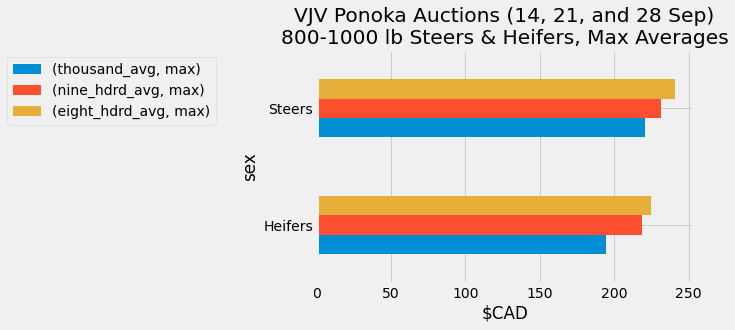

<Figure size 1440x864 with 0 Axes>

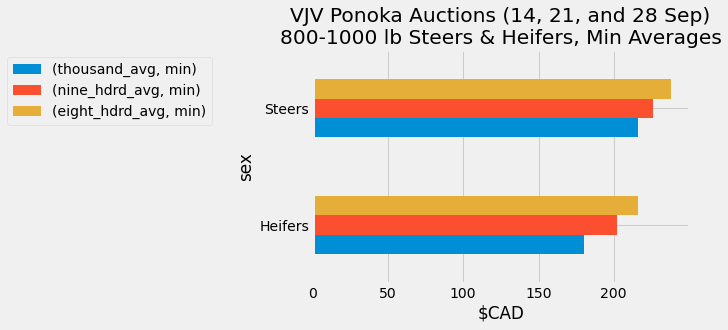

<Figure size 1440x864 with 0 Axes>

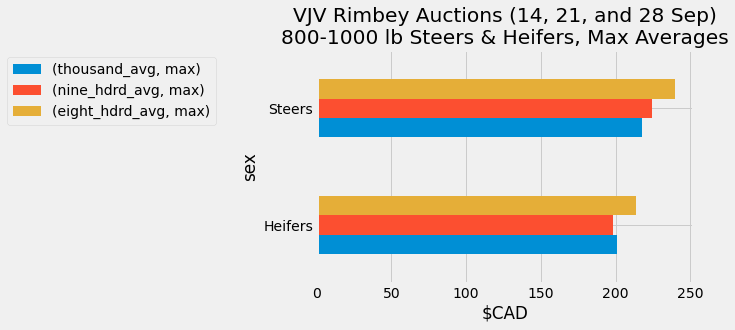

<Figure size 1440x864 with 0 Axes>

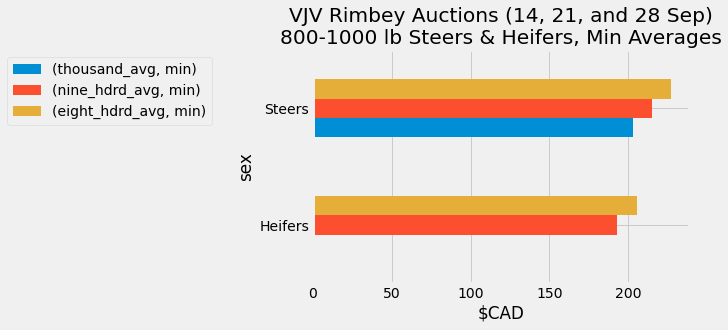

<Figure size 1440x864 with 0 Axes>

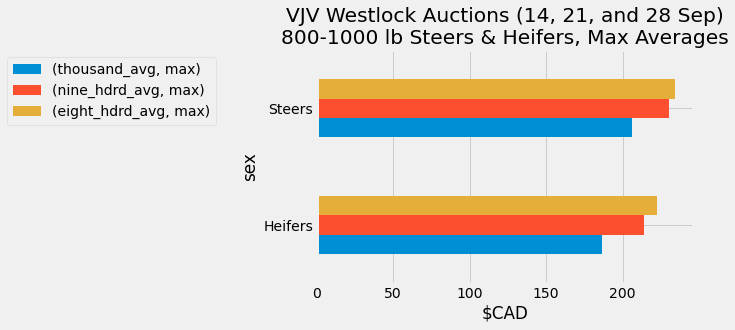

<Figure size 1440x864 with 0 Axes>

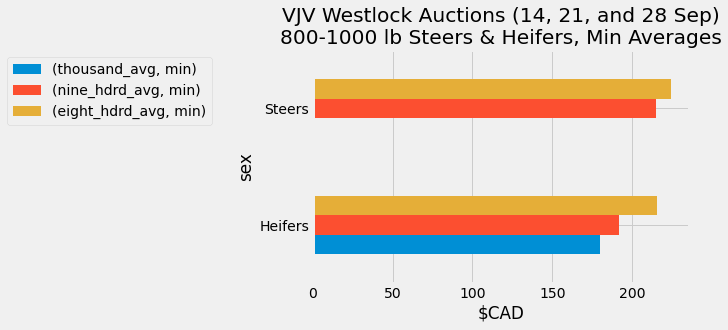

In [104]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(20, 12))
ponoka_df[['sex', 'thousand_avg', 'nine_hdrd_avg', 'eight_hdrd_avg']].groupby('sex').agg(['max']).plot.barh()
plt.title('VJV Ponoka Auctions (14, 21, and 28 Sep)\n800-1000 lb Steers & Heifers, Max Averages')
plt.xlabel('$CAD')
plt.legend(bbox_to_anchor=(-0.25,1))

plt.show()

plt.figure(figsize=(20, 12))
ponoka_df[['sex', 'thousand_avg', 'nine_hdrd_avg', 'eight_hdrd_avg']].groupby('sex').agg(['min']).plot.barh()
plt.title('VJV Ponoka Auctions (14, 21, and 28 Sep)\n800-1000 lb Steers & Heifers, Min Averages')
plt.xlabel('$CAD')
plt.legend(bbox_to_anchor=(-0.25,1))

plt.show()

plt.figure(figsize=(20, 12))
rimbey_df[['sex', 'thousand_avg', 'nine_hdrd_avg', 'eight_hdrd_avg']].groupby('sex').agg(['max']).plot.barh()
plt.title('VJV Rimbey Auctions (14, 21, and 28 Sep)\n800-1000 lb Steers & Heifers, Max Averages')
plt.xlabel('$CAD')
plt.legend(bbox_to_anchor=(-0.25,1))

plt.show()

plt.figure(figsize=(20, 12))
rimbey_df[['sex', 'thousand_avg', 'nine_hdrd_avg', 'eight_hdrd_avg']].groupby('sex').agg(['min']).plot.barh()
plt.title('VJV Rimbey Auctions (14, 21, and 28 Sep)\n800-1000 lb Steers & Heifers, Min Averages')
plt.xlabel('$CAD')
plt.legend(bbox_to_anchor=(-0.25,1))

plt.show()

plt.figure(figsize=(20, 12))
westlock_df[['sex', 'thousand_avg', 'nine_hdrd_avg', 'eight_hdrd_avg']].groupby('sex').agg(['max']).plot.barh()
plt.title('VJV Westlock Auctions (14, 21, and 28 Sep)\n800-1000 lb Steers & Heifers, Max Averages')
plt.xlabel('$CAD')
plt.legend(bbox_to_anchor=(-0.25,1))

plt.show()

plt.figure(figsize=(20, 12))
westlock_df[['sex', 'thousand_avg', 'nine_hdrd_avg', 'eight_hdrd_avg']].groupby('sex').agg(['min']).plot.barh()
plt.title('VJV Westlock Auctions (14, 21, and 28 Sep)\n800-1000 lb Steers & Heifers, Min Averages')
plt.xlabel('$CAD')
plt.legend(bbox_to_anchor=(-0.25,1))